In [1]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import PartialDependenceDisplay
import math
import shap

'''The point of this section is to A) import the dataset, B) drop unecessary columns (assuming you need to), C) rename columns (if you want),
and then D) adjust data types. This file specifically deals with the distance values extracted in meters, which were "how far away, in meters, the nearest POI was".'''


#Load the dataset. Atlanta_Nearest_Distances.csv is the dataset being used. It is essentially a placeholder. 
#It is also assuming this is a LOCAL file that was downloaded directly to the computer, hence the location. This can be replaced with anything, like a git location. 
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv') 

#Combine redundant columns. The two baths columns are addressing the same overall feature, they can be combined into "total baths", like "total bedrooms".
#Half baths is multiplied by .5 of a value because it is "half of a full bath"
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)

#Drop any columns you aren't analyzing. This was taken from a baseline, where columns to be included were decided later. 
Atlanta_Distance = Atlanta_Distance.drop(columns=['latitude',
                                                  'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'has_pool', 'has_garage', 'number_of_garage_spaces', 'listing_date', 'number_of_stories', 'lot_size_in_square_feet',
                                                 'Supercenter_POI', 'Convenience_POI', 'Supermarket_POI', 'Wholesale_POI', 'Variety_Store_POI', 'story_indicator'])

#Rename columns for clarity. 
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                'year_built': 'Year Built'})

#"Year built" is read as a float OR as a string, it should be read as an integer. For numerical analysis, use int or float if there are missing values, which "year built" has.
Atlanta_Distance['Year Built'] = Atlanta_Distance['Year Built'].astype('Int64')

#We want to group by the street_address because Excel does not order duplicates the same way as Python. So, if this method was done in a different notebook without grouping, the ordering might accidentally be different, causing a different result because of the NAN values.
Atlanta_Distance = Atlanta_Distance.groupby(["street_address"]).max().reset_index(drop = False)
Atlanta_Distance

,street_address,current_listing_price,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,0 ivy MNR DR NW 0,2865,2002,4,3259.0,10917.45,6405.99,1654.08,2539.28,2715.74,2.5
1,1 10 buena VIS CIR SE,2200,<NA>,3,1993.0,32739.68,405.11,3065.55,492.63,1407.26,2.0
2,1 1088 coldwater DR,2000,<NA>,3,1910.0,29267.11,4738.04,3780.13,25413.80,3213.19,2.0
3,1 1130 willivee DR,1995,<NA>,3,1134.0,9020.53,4356.55,2320.59,7857.71,2385.60,1.0
4,1 1307 idlewood CT,2800,<NA>,4,2532.0,14750.79,6721.22,5625.35,11676.91,14263.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...
19213,procurement only - 66 4th ST,1600,<NA>,3,1367.0,47285.12,6409.21,2097.35,19852.16,4983.93,2.0
19214,r2188 executive DR,2199,<NA>,3,1696.0,2009.36,6142.54,888.22,4864.86,1477.04,2.5
19215,r3339 woodward down,2380,2015,3,1944.0,1507.23,714.63,1158.08,1359.41,3952.51,3.5
19216,singleunit 216 greensprings DR,1900,<NA>,4,1204.0,40632.51,1402.52,8779.81,10787.35,1242.13,2.0


In [2]:
'''We now want to create a pipeline for the dataset, focusing on the numeric features. We begin by selecting just the numeric features, applying a scaler transformer,
and then merging that into a preprocessor'''


# Exclude 'current_listing_price' from features, since this is your target. This will also automatically be excluding street_address, a categorical variable, as that was just being used for grouping.
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

# Pipeline for numeric features: Impute missing values using mean (you may also do median), and then use a scaler for the numeric values. 
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combined preprocessor for numeric. The preprocessor applies the transformer (filling in the means and scaling the data) to the numeric features. This prevents data leakage
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
])

#Apply preprocessor to original data (this isn't really necessary for this model, but can be useful for others like the MLR) 
transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [3]:
# Create a list from the numeric features to check if columns were selected correctly.
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

In [4]:
#Create a dataframe from the applied preprocessor with the list to see the results. This is "technically" not necessary, only if you need to see the data itself.
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,5.068264e-01,0.670187,1.319220,-0.637664,0.553332,-0.544204,-0.855180,-0.545599,0.189453
1,1.073134e-14,-0.440415,0.101174,1.485733,-1.143762,-0.090871,-1.211535,-0.962407,-0.465279
2,1.073134e-14,-0.440415,0.021318,1.147837,0.081623,0.138637,3.127638,-0.387139,-0.465279
3,1.073134e-14,-0.440415,-0.725288,-0.822242,-0.026265,-0.330136,0.070843,-0.650763,-1.774741
4,1.073134e-14,0.670187,0.619757,-0.264663,0.642481,0.731281,0.735827,3.132781,-0.465279
...,...,...,...,...,...,...,...,...,...
19213,1.073134e-14,-0.440415,-0.501114,2.901067,0.554242,-0.401836,2.159268,0.176920,-0.465279
19214,1.073134e-14,-0.440415,-0.184576,-1.504459,0.478826,-0.790182,-0.450260,-0.940179,0.189453
19215,1.120386e+00,-0.440415,0.054030,-1.553319,-1.056228,-0.703509,-1.060615,-0.151633,1.498915
19216,1.073134e-14,0.670187,-0.657940,2.253740,-0.861687,1.744424,0.580940,-1.015008,-0.465279


In [5]:
'''Next is to create the initial model. This model calls for a train-test-validation split, also called a three-way split. First, the model needs to be defined and
put into the pipeline. Then, the split needs to be defined. This is explained in detail in the code. After this is done, the pipeline should be fit on the training set.
An XGBoost model builds decision trees sequentially, pruning results as it improves upon the mistakes of the previous tree.'''

# Define the full model pipeline including the preprocessor. You can "recall" parts of the pipeline using their string names. 
#For example, if you wanted to just use the model, you'd use 'regressor__' before loading. 
#Random_state is used here to prevent randomization when the model is ran, keeping more consistent results. 
xgb_model = XGBRegressor(random_state=42)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

#1. Split the dataset into a train set and a test set.
#2. Split the training data further into a training set and a validation set.
#3. Use the validation set for tuning, then assess performance on the test set.

X = Atlanta_Distance.drop(columns='current_listing_price') #This can also be replaced with "transformed_df", as, again, they do the same thing. 
y = Atlanta_Distance['current_listing_price'] #transformed_df does not have the target, as it's not supposed to be transformed, so it can't be replaced here.
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #This splits your data into 80% (X_train_val) and 20% (X_test)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) #X_train_val data is further split into 60% train set (X_train) and 20% validation (X_val)
#Note: the test_size=0.25 is used to split the remaining training and validation set into 75% training and 25% validation (75% of 80% = 60%)
pipeline.fit(X_train, y_train) #The pipeline is fit on the training data and evaluated on the validation set (X_val)


#Test Set (X_test): This set is a held-out portion of the data that the model has never seen during training or tuning, making it the best indicator of the model's generalization performance. The test score tells you how well the model is likely to perform on truly unseen data, which is typically the main goal.

#Validation Set (X_val): The validation set is primarily used during model selection and hyperparameter tuning. It gives a good intermediate measure of model performance, but since it has influenced model tuning, it can no longer be considered a truly unbiased assessment of generalization.

#Combined Train-Validation Set (X_train_val): This set is used for final training once the best model has been selected. While scores on this set give an idea of how well the model fits on a larger amount of data, they do not represent true generalization performance, as the data has been used for model tuning and training.

#Training Set (X_train): The training set score can help diagnose underfitting or overfitting during development, but it isn’t relevant as a final evaluation metric because it doesn’t measure how well the model generalizes.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_score=None...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [6]:
'''We then "can" calculate the R^2, Mean Squared Error, Root Mean Squared Error, and Mean Absolute Percentage Error for the default sets.
However, these values are typically lower because they aren't tuned.'''

#This is the cross-validation score. A higher R^2 usually means a better model.
#The goal is to have the test score be as close to the train-val score as possible. This score can be used to compare your future model against, but, 
#unless specified, only a tuned model would be preferred since that is supposed to have a higher score
val_score = pipeline.score(X_val, y_val)
print('Validation R^2:', val_score)

test_score = pipeline.score(X_test, y_test)
print('Test R^2:', test_score)

Validation R^2: 0.5563383102416992
Test R^2: 0.571368932723999


In [7]:
#This is how you would manually calculate the Mean Squared Error without using some kind of function, using "predict". First, create a y_predict value from the X through the pipeline.
y_val_pred = pipeline.predict(X_val)

#Then, you can calculate the MSE by having the predict value be the new "y value" and the original y value as the x. The lower the score, typically the better the model.
val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)

#To find RMSE, simply square root the MSE
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

#This is the same, except it's being done on the test set instead of the validation set. 
y_test_pred = pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 414812.3298135584
Validation Root Mean Squared Error: 644.0592595511366
Test Mean Squared Error: 361065.4650895721
Test Root Mean Squared Error: 600.8872315913961


In [8]:
#You can calculate MAPE using a function, which then borrows the same variables from the MSE. 
def calculate_mape(actual, predicted):
    """
    Calculate the Mean Absolute Percentage Error (MAPE) between actual and predicted values.

    MAPE is a metric that expresses the prediction error as a percentage of the actual values. 
    It is calculated by taking the average of the absolute percentage differences between the 
    actual and predicted values.

    Parameters:
    ----------
    actual : array-like
        The true target values or ground truth.
    predicted : array-like
        The predicted values from the model.

    Returns:
    -------
    float
        The MAPE value, representing the average percentage error. Lower values indicate better 
        model performance. A perfect score is 0.0, while higher values indicate greater error.
    """
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape) #A lower MAPE value indicates a more accurate prediction

Validation Mean Absolute Percentage Error (MAPE): 15.61705411056272
Test Mean Absolute Percentage Error (MAPE): 15.381474688233125


In [9]:
'''Hyperparameter tuning is used to improve the scores of the default values. First, a grid, or layout, must be created for your model.
Then, you can actually combine all the scoring into one "gridsearch", which is the method we'll use to tune. It is more efficient, but slower than randomized searching.'''


# Create a Stratified KFold object. This is used for cross-validation, taking into account randomization. 
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [400],          # The number of boosting rounds or trees. Higher values may improve model performance but also increase training time. 
    'regressor__learning_rate': [0.1],        # Controls the impact of each boosting round on the final model. Lower values make learning more gradual and can improve accuracy, though may require more trees.
    'regressor__max_depth': [4],               # Maximum depth of each tree. Limits complexity; lower values reduce overfitting, while higher values can capture more complex patterns.
    'regressor__subsample': [0.8],             # Fraction of the training data used per boosting round. Values below 1.0 can prevent overfitting by introducing randomness.
    'regressor__colsample_bytree': [0.8],      # Fraction of features sampled to train each tree. Lower values prevent overfitting by adding randomness, which can improve generalization.
    'regressor__alpha': [10],                  # L1 regularization term on weights, similar to Lasso regression. Helps to make the model simpler by forcing some feature weights to be zero, reducing overfitting.
    'regressor__lambda': [10]                  # L2 regularization term on weights, similar to Ridge regression. Helps to make the model more stable and reduces overfitting.
}

# Multi-scoring in GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline, #Input your pipeline, it's technically using the regressor. 
    param_grid=param_grid, #self-explanatory, but this is where you input the parameter grid. 
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],  # We're using multiple score, so list out which scoring methods you want to use in brackets.
    refit='r2',  # Specify which metric to refit when it comes to multiple scoring. R2 is used by default.
    cv=kf, #What cross-validation is being used, here we're using the k-fold. You could also just say '10' for 10 folds. 
    n_jobs=-1, #This just uses all of your computer's processing power.
    verbose=2 #This is logging information
)
grid_search.fit(X_train, y_train) #Literally the equivalent of pipeline.fit, but now we're working with the grid_search

best_model = grid_search.best_estimator_ #Best_model is technically irrelevant because the this model is already narrowed down by what the best model is.
#However, if you had multiple models searches, like different numbers for esitmators, it'll find which one leads to the best score. 

# Best score is the "best mean cross-validation score", based on the training set. Best params was already chosen for us, but it's the parameters that gives the highest scores.
results = grid_search.cv_results_
print("Best parameters:", grid_search.best_params_)
print("Best R^2:", grid_search.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 10, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Best R^2: 0.5432648718357086


In [10]:
'''This next section will be used in a different notebook in order to conduct statistical tests between the various models. Essentially, the goal is to 
extract the individual fold scores and then export them as a pickle file'''

# List of metrics used in scoring
metrics = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']

# Access cv_results_ from the grid search
cv_results = grid_search.cv_results_

# Get the number of folds used in cross-validation
n_folds = kf.get_n_splits()

# Extract fold-wise scores for each metric
fold_scores = {f'Fold {i + 1}': {metric: cv_results[f'split{i}_test_{metric}'][grid_search.best_index_] for metric in metrics}
               for i in range(n_folds)}

# Convert the scores into a DataFrame
distance_scores = pd.DataFrame(fold_scores).T

# Rename the columns for clarity
distance_scores.columns = ['R²', 'MSE', 'MAPE', 'RMSE']

# Display the DataFrame
print("Scores Distance (Folds as Rows, Metrics as Columns):")
print(distance_scores)
distance_scores.to_pickle("./Scores/distance_scores.pkl")

Scores Distance (Folds as Rows, Metrics as Columns):
               R²            MSE      MAPE        RMSE
Fold 1   0.590010 -274064.098821 -0.151202 -523.511317
Fold 2   0.578761 -411366.800890 -0.153617 -641.378828
Fold 3   0.564698 -349271.131828 -0.155700 -590.991651
Fold 4   0.432204 -362138.075966 -0.142460 -601.779092
Fold 5   0.487554 -400383.504335 -0.158953 -632.758646
Fold 6   0.547276 -357638.293469 -0.150569 -598.028673
Fold 7   0.490598 -395666.689380 -0.151238 -629.020420
Fold 8   0.594524 -298023.834402 -0.158071 -545.915593
Fold 9   0.588380 -328988.714710 -0.149162 -573.575378
Fold 10  0.558643 -382865.921190 -0.165777 -618.761603


In [11]:
def calculate_scores(y_true, y_pred):
    """
    Calculate and return multiple regression evaluation metrics.

    This function computes the R² score, Mean Squared Error (MSE), 
    Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) 
    for a set of true values and predicted values, providing a comprehensive 
    evaluation of model performance.

    Parameters:
    ----------
    y_true : array-like
        The true target values.
    y_pred : array-like
        The predicted target values from the model.

    Returns:
    -------
    tuple
        A tuple containing the following scores:
        - r2 : float : R² score, indicating the proportion of variance explained by the model.
        - mse : float : Mean Squared Error, measuring the average squared difference between 
          the predicted and actual values.
        - mape : float : Mean Absolute Percentage Error, showing the average percentage error.
        - rmse : float : Root Mean Squared Error, providing an interpretable measure of 
          prediction error in the original units of the target variable.
    """
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return r2, mse, mape, rmse

In [12]:
'''We now want to create a method to calculate the scores for every set.
Using the previous function, we merely use it against each version of "best model" predicted against each set.'''
#You "can" refit the model on the train_val set under the pretense that it will give a better score. This is assuming there isn't egregious overfitting.
#Refitting the model has the least amount of impact on the test score. 
best_model.fit(X_train_val, y_train_val)

#Applies the function to the val set
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

#Applies the function to the test set
y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

#Applies the function to the train-val set
y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_train_val, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.7170
MSE: 264625.4240
MAPE: 0.1334
RMSE: 514.4176

Tuned Test Set Scores:
R²: 0.6042
MSE: 333416.2553
MAPE: 0.1493
RMSE: 577.4221

Tuned Train-Val Set Scores:
R²: 0.7165
MSE: 232965.2795
MAPE: 0.1319
RMSE: 482.6648


In [13]:
'''The next step is to create an identifier for feature importance, usually done through a graph. 
You would take the "best model" and all of its feature names, sort it, and then extract the importance.'''

#This is technically redundant, but what it's recalling the best model from the pipeline.
best_xgb_model = best_model.named_steps['regressor']

#This is getting the feature importances from the best model
feature_importances = best_xgb_model.feature_importances_

#You first sort the feature importances in descending order, then you turn it into an array.
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

#This function allows for naming and rounding of the features and the listed importances. The result should show the feature names and their importances, sorted.
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Total Bathrooms, Importance: 0.2583
Feature: Living Area(SQF), Importance: 0.2467
Feature: Total Bedrooms, Importance: 0.0860
Feature: Wholesale, Importance: 0.0855
Feature: Year Built, Importance: 0.0832
Feature: Supermarket, Importance: 0.0752
Feature: Supercenter, Importance: 0.0636
Feature: Convenience, Importance: 0.0615
Feature: Variety Store, Importance: 0.0399


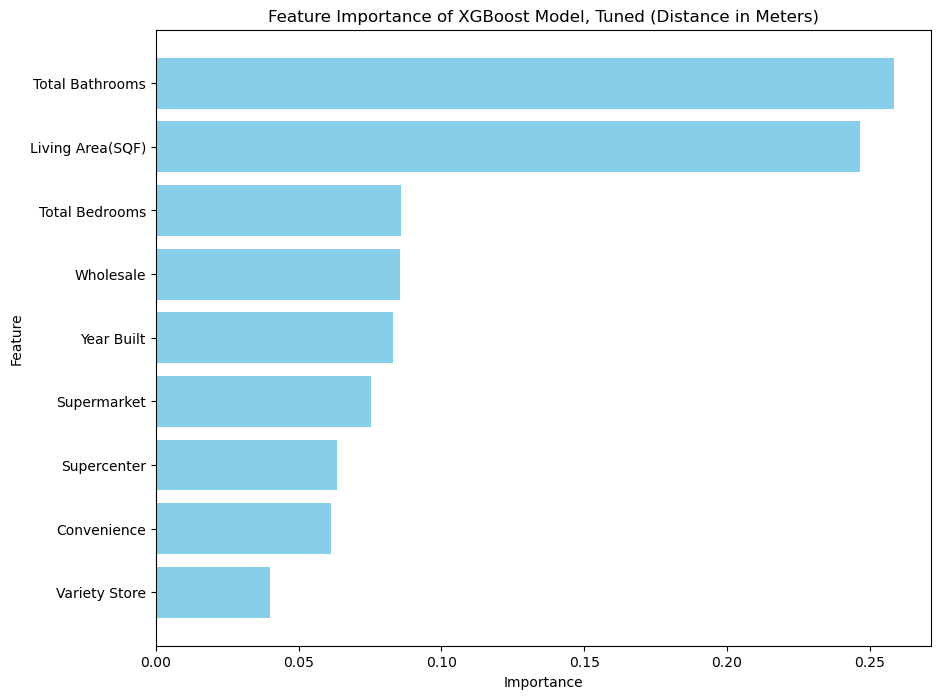

In [14]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
#Save graph (folder_path + file_name)
plt.savefig("./Graphs/" + 'distance_feature_importance.png')
plt.show()

#The feature importance scores remain consistent regardless of the train, test, or train-val set. 

In [15]:
all_feature_names #This was just called as a reminder for the next step. 

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

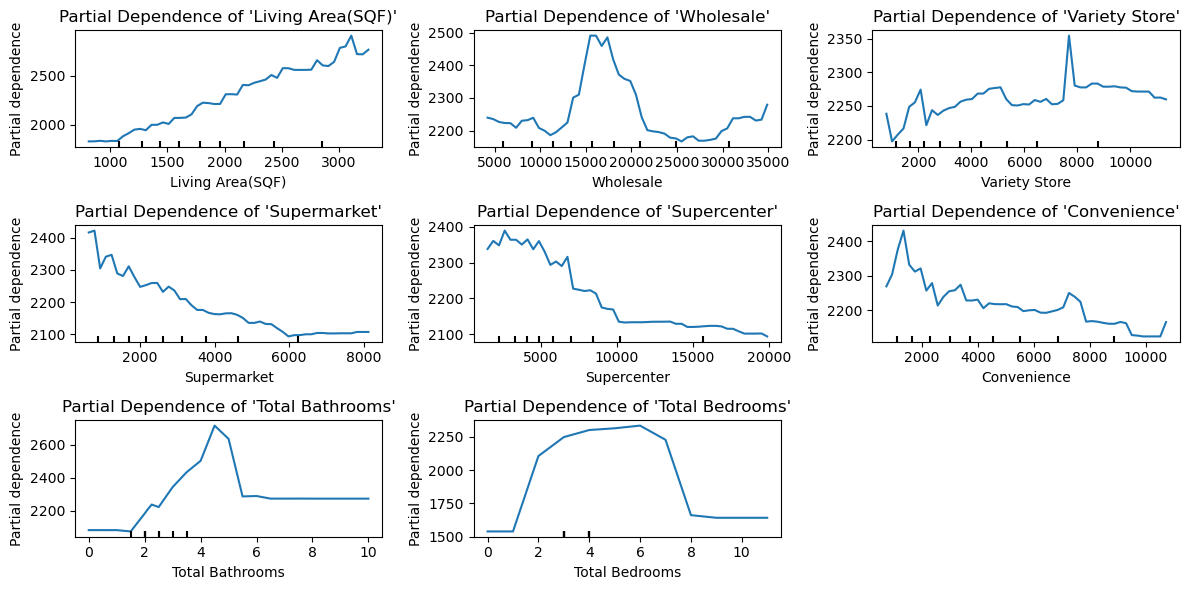

In [16]:
"""
Generates Partial Dependence Plots (PDPs) for specified features to visualize their effect on the model’s predictions. 
Each plot shows the marginal relationship between a feature and the predicted outcome, with all other features averaged out. 
Useful for understanding how changes in individual features impact the model’s predictions.

Parameters:
- best_model: The trained model object from which to generate the PDPs.
- X_train_val: The training (or training-validation) dataset containing feature columns.
- features: A list of feature names (as strings) for which to generate PDPs.
"""

# List of features to include in the Partial Dependence Plots
features = [
    'Living Area(SQF)', 'Wholesale', 'Variety Store', 'Supermarket', 
    'Supercenter', 'Convenience', 'Total Bathrooms', 'Total Bedrooms'
]

# Set up the grid layout based on the number of features
n_features = len(features)  # Total number of features to plot
n_cols = 3  # Number of columns in the grid layout
n_rows = math.ceil(n_features / n_cols)  # Calculate number of rows needed

# Create a figure with subplots arranged in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))
axes = axes.ravel()  # Flatten the axes array to simplify indexing

# Loop through each feature and generate a PDP on a subplot
for i, feature in enumerate(features):
    # Generate the Partial Dependence Plot for the current feature
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train_val,  # Use the training dataset (or training-validation) for PDP
        [feature],
        grid_resolution=50,  # Resolution of the grid for smoothness of the PDP
        ax=axes[i]  # Place the plot on the specified subplot axis
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set a title for each plot

# Hide any empty subplots if the grid is larger than the number of features
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to ensure subplots do not overlap and labels are clear
plt.tight_layout()
#Save graph (folder_path + file_name)
plt.savefig("./Graphs/" + 'distance_PDP.png')
plt.show()

 97%|=================== | 3747/3844 [00:23<00:00]       

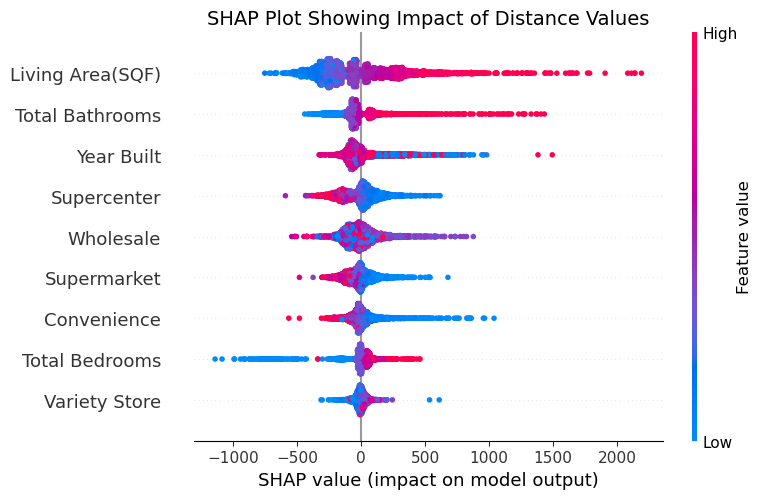

In [17]:
'''Perhaps the greatest curiosity is if the results actually mean anything. Therefore, a SHAP graph can be created to display the impact.
In summary, the features in red are the increase in data values. Features in blue are the decrease in data values. The graph itself is their impact 
on housing values.'''

# Extract preprocessor and model
preprocessor = best_model.named_steps['preprocessor']
model = best_model.named_steps['regressor']

# Preprocess the data. For the trainer, the data that was passed is being used. We passed the train-val in the refitted model. 
X_train_val_processed = preprocessor.transform(X_train_val)
X_test_processed = preprocessor.transform(X_test)

# Create SHAP explainer with the standalone model
explainer = shap.Explainer(model, X_train_val_processed, feature_names = all_feature_names)

# Compute SHAP values
shap_values = explainer(X_test_processed)

# Visualize SHAP summary
shap.summary_plot(shap_values, X_test_processed, feature_names = all_feature_names, show=False)
# Add a title using Matplotlib
plt.title("SHAP Plot Showing Impact of Distance Values", fontsize=14)
plt.tight_layout()  # Adjust layout to prevent overlap
#Save graph (folder_path + file_name)
plt.savefig("./Graphs/" + 'distance_SHAP.png')
plt.show()

In [18]:
"""
The following is an attempt to extract the scores from the baseline model. A baseline is all independent variables except any variables that were added 
as part of the project. In this case, that would be anything related to the grocery stores. "b" literally represents baseline.
The outline for everything is otherwise identical. 
"""

#Drop distance columns
Atlanta_Baseline = Atlanta_Distance.drop(columns=['Wholesale','Variety Store','Supermarket','Supercenter','Convenience'])
Atlanta_Baseline

,street_address,current_listing_price,Year Built,Total Bedrooms,Living Area(SQF),Total Bathrooms
0,0 ivy MNR DR NW 0,2865,2002,4,3259.0,2.5
1,1 10 buena VIS CIR SE,2200,<NA>,3,1993.0,2.0
2,1 1088 coldwater DR,2000,<NA>,3,1910.0,2.0
3,1 1130 willivee DR,1995,<NA>,3,1134.0,1.0
4,1 1307 idlewood CT,2800,<NA>,4,2532.0,2.0
...,...,...,...,...,...,...
19213,procurement only - 66 4th ST,1600,<NA>,3,1367.0,2.0
19214,r2188 executive DR,2199,<NA>,3,1696.0,2.5
19215,r3339 woodward down,2380,2015,3,1944.0,3.5
19216,singleunit 216 greensprings DR,1900,<NA>,4,1204.0,2.0


In [19]:
numeric_features_b = Atlanta_Baseline.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns

#We don't have to do anything additional with the preprocessor since that was already done for us in the distance model. The only thing different is the number of features, hence the new numeric variable.
preprocessor_b = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_b),
])
transformed_data_b = preprocessor_b.fit_transform(Atlanta_Baseline)
all_feature_names_b = list(numeric_features_b)
transformed_df_b = pd.DataFrame(transformed_data_b, columns=all_feature_names_b)
transformed_df_b

,Year Built,Total Bedrooms,Living Area(SQF),Total Bathrooms
0,5.068264e-01,0.670187,1.319220,0.189453
1,1.073134e-14,-0.440415,0.101174,-0.465279
2,1.073134e-14,-0.440415,0.021318,-0.465279
3,1.073134e-14,-0.440415,-0.725288,-1.774741
4,1.073134e-14,0.670187,0.619757,-0.465279
...,...,...,...,...
19213,1.073134e-14,-0.440415,-0.501114,-0.465279
19214,1.073134e-14,-0.440415,-0.184576,0.189453
19215,1.120386e+00,-0.440415,0.054030,1.498915
19216,1.073134e-14,0.670187,-0.657940,-0.465279


In [20]:
#The model is technically the same, but it was repeated for clarity.
xgb_model = XGBRegressor(random_state=42)
pipeline_b = Pipeline([
    ('preprocessor_b', preprocessor_b),
    ('regressor', xgb_model)
])

#Everything has to have a new variable and be refitted because it's now being applied to a "new" set of features. 
X_b = Atlanta_Baseline.drop(columns='current_listing_price')
y_b = Atlanta_Baseline['current_listing_price']
X_train_val_b, X_test_b, y_train_val_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_val_b, y_train_val_b, test_size=0.25, random_state=42)
pipeline_b.fit(X_train_b, y_train_b)

Pipeline(steps=[('preprocessor_b',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Total Bathrooms'], dtype='object'))])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynod...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [21]:
#Our previous scores were Validation: 0.5563383102416992 and Test 0.571368932723999, for comparison. 

val_score_b = pipeline_b.score(X_val_b, y_val_b) 
print('Validation R^2:', val_score_b)

test_score_b = pipeline_b.score(X_test_b, y_test_b) 
print('Test R^2:', test_score_b)

Validation R^2: 0.38495951890945435
Test R^2: 0.4431343078613281


In [22]:
#The parameters need to be adjusted because of the reduced features. This was determined to be optimal. 
param_grid_b = {
    'regressor__n_estimators': [200],
    'regressor__learning_rate': [0.1],
    'regressor__max_depth': [6],
    'regressor__subsample': [0.8],
    'regressor__colsample_bytree': [0.8],
    'regressor__alpha': [10],
    'regressor__lambda': [10]
}


grid_search_b = GridSearchCV(
    estimator=pipeline_b,
    param_grid=param_grid_b,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],  # Multiple scoring
    refit='r2',  # Specify which metric to refit
    cv=kf,
    n_jobs=-1,
    verbose=2
)


grid_search_b.fit(X_train_b, y_train_b)

best_model_b = grid_search_b.best_estimator_

# Access the results
results_b = grid_search_b.cv_results_
print("Best parameters:", grid_search_b.best_params_)
print("Best R^2:", grid_search_b.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 10, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best R^2: 0.3971900463104248


In [23]:
'''We must also extract the baseline scores, repeating the same process'''

# List of metrics used in scoring
metrics_b = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']

# Access cv_results_ from the grid search
cv_results_b = grid_search_b.cv_results_

# Extract fold-wise scores for each metric. Number of folds is the same, so it doesn't need to be changed.
fold_scores_b = {f'Fold {i + 1}': {metric: cv_results_b[f'split{i}_test_{metric}'][grid_search_b.best_index_] for metric in metrics}
               for i in range(n_folds)}

# Convert the scores into a DataFrame
baseline_scores = pd.DataFrame(fold_scores_b).T

# Rename the columns for clarity
baseline_scores.columns = ['R²', 'MSE', 'MAPE', 'RMSE']

# Display the DataFrame
print("Scores Baseline (Folds as Rows, Metrics as Columns):")
print(baseline_scores)
baseline_scores.to_pickle("./Scores/baseline_scores.pkl")

Scores Baseline (Folds as Rows, Metrics as Columns):
               R²            MSE      MAPE        RMSE
Fold 1   0.405541 -397374.893760 -0.174976 -630.376787
Fold 2   0.456611 -530653.876667 -0.176517 -728.459935
Fold 3   0.341678 -528214.722282 -0.173766 -726.783821
Fold 4   0.292917 -450975.149407 -0.168028 -671.546833
Fold 5   0.366453 -495001.939294 -0.171967 -703.563742
Fold 6   0.422265 -456392.626667 -0.167985 -675.568373
Fold 7   0.400822 -465397.789632 -0.167044 -682.200696
Fold 8   0.437628 -413342.139577 -0.180967 -642.916899
Fold 9   0.476132 -418703.528429 -0.170400 -647.073047
Fold 10  0.371851 -544902.661174 -0.189137 -738.175224


In [24]:
best_model_b.fit(X_train_val_b, y_train_val_b)

y_val_pred_tuned_b = best_model_b.predict(X_val_b)
val_scores_b = calculate_scores(y_val_b, y_val_pred_tuned_b)

y_test_pred_tuned_b = best_model_b.predict(X_test_b)
test_scores_b= calculate_scores(y_test_b, y_test_pred_tuned_b)

y_combined_pred_tuned_b = best_model_b.predict(X_train_val_b)
combined_scores_b = calculate_scores(y_train_val_b, y_combined_pred_tuned_b)

print("Tuned Baseline Validation Set Scores:")
print(f"R²: {val_scores_b[0]:.4f}")
print(f"MSE: {val_scores_b[1]:.4f}")
print(f"MAPE: {val_scores_b[2]:.4f}")
print(f"RMSE: {val_scores_b[3]:.4f}")

print("\nTuned Baseline Test Set Scores:")
print(f"R²: {test_scores_b[0]:.4f}")
print(f"MSE: {test_scores_b[1]:.4f}")
print(f"MAPE: {test_scores_b[2]:.4f}")
print(f"RMSE: {test_scores_b[3]:.4f}")

print("\nTuned Baseline Train-Val Set Scores:")
print(f"R²: {combined_scores_b[0]:.4f}")
print(f"MSE: {combined_scores_b[1]:.4f}")
print(f"MAPE: {combined_scores_b[2]:.4f}")
print(f"RMSE: {combined_scores_b[3]:.4f}")

Tuned Baseline Validation Set Scores:
R²: 0.5875
MSE: 385699.1357
MAPE: 0.1585
RMSE: 621.0468

Tuned Baseline Test Set Scores:
R²: 0.4764
MSE: 441042.7435
MAPE: 0.1686
RMSE: 664.1105

Tuned Baseline Train-Val Set Scores:
R²: 0.5805
MSE: 344791.1960
MAPE: 0.1561
RMSE: 587.1892


In [25]:
#You can call the previous scores for comparison by simply recalling the previous variables. Notice how it's the identical print as the baseline just without the "_b" attached to the variables.
#We can see just how much lower the baseline is in comparison.

print("Tuned Distance Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Distance Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Distance Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned Distance Validation Set Scores:
R²: 0.7170
MSE: 264625.4240
MAPE: 0.1334
RMSE: 514.4176

Tuned Distance Test Set Scores:
R²: 0.6042
MSE: 333416.2553
MAPE: 0.1493
RMSE: 577.4221

Tuned Distance Train-Val Set Scores:
R²: 0.7165
MSE: 232965.2795
MAPE: 0.1319
RMSE: 482.6648


In [26]:
best_xgb_model_b = best_model_b.named_steps['regressor']
feature_importances_b = best_xgb_model_b.feature_importances_
sorted_indices_b = np.argsort(feature_importances_b)[::-1]
sorted_feature_importances_b = feature_importances_b[sorted_indices_b]
sorted_feature_names_b = np.array(all_feature_names_b)[sorted_indices_b]
for name, importance in zip(sorted_feature_names_b, sorted_feature_importances_b):
    print(f"Feature: {name}, Importance: {importance:.4f}") #There's only four features now because we removed most of the features.

Feature: Living Area(SQF), Importance: 0.3895
Feature: Total Bathrooms, Importance: 0.3266
Feature: Year Built, Importance: 0.1625
Feature: Total Bedrooms, Importance: 0.1214


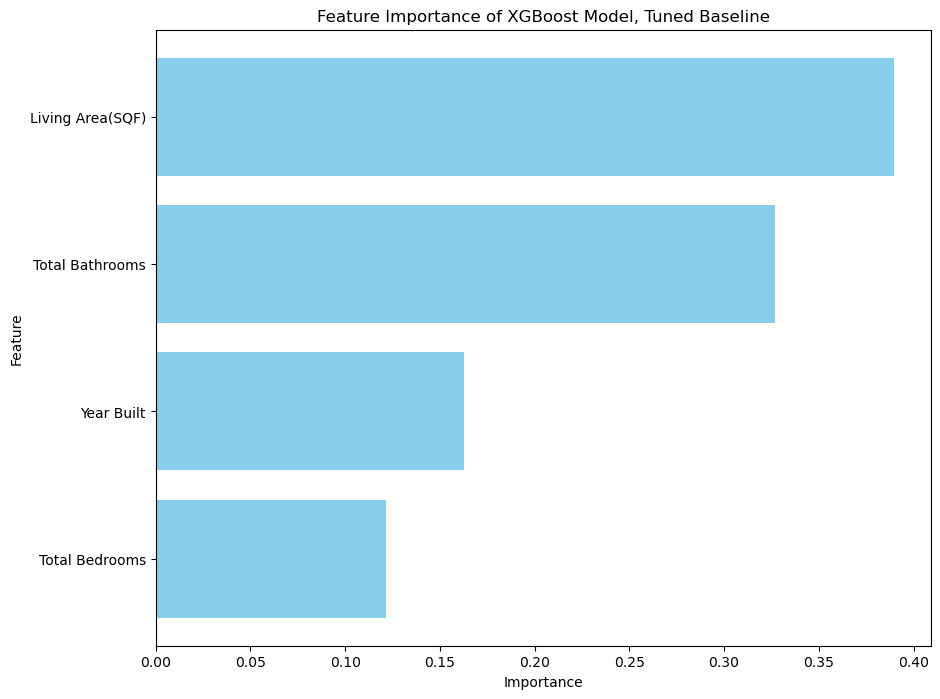

In [27]:
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_b, sorted_feature_importances_b, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned Baseline')
plt.gca().invert_yaxis()
#Save graph (folder_path + file_name)
plt.savefig("./Graphs/" + 'baseline_feature_importance.png')
plt.show()

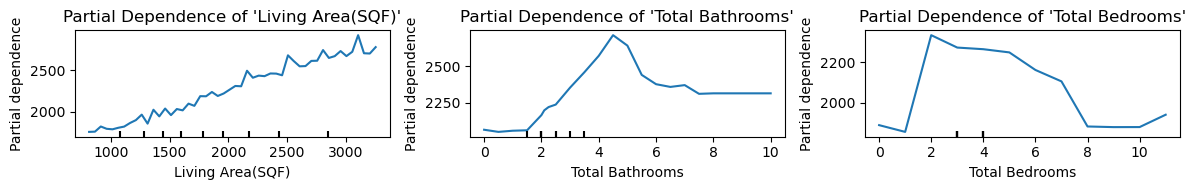

In [28]:
#Make sure the correct features are selected. Year built cannot be selected due to issues with NAN values. 
features = [
    'Living Area(SQF)', 'Total Bathrooms', 'Total Bedrooms'
]

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_b,
        X_train_val_b, 
        [feature],
        grid_resolution=50,
        ax=axes[i]  # Place in the correct subplot
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

 96%|=================== | 3696/3844 [00:19<00:00]       

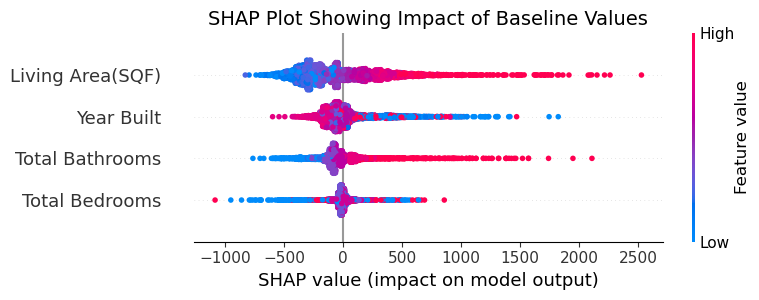

In [29]:
# Extract preprocessor and model
preprocessor_b = best_model_b.named_steps['preprocessor_b']
model_b = best_model_b.named_steps['regressor']

# Preprocess the data. For the trainer, the data that was passed is being used. We passed the train-val in the refitted model. 
X_train_val_processed_b = preprocessor_b.transform(X_train_val_b)
X_test_processed_b = preprocessor_b.transform(X_test_b)

# Create SHAP explainer with the standalone model
explainer_b = shap.Explainer(model_b, X_train_val_processed_b, feature_names = all_feature_names_b)

# Compute SHAP values
shap_values_b = explainer_b(X_test_processed_b)

# Visualize SHAP summary
shap.summary_plot(shap_values_b, X_test_processed_b, feature_names = all_feature_names_b, show=False)
# Add a title using Matplotlib
plt.title("SHAP Plot Showing Impact of Baseline Values", fontsize=14)
plt.tight_layout()  # Adjust layout to prevent overlap
#Save graph (folder_path + file_name)
plt.savefig("./Graphs/" + 'baseline_SHAP.png')
plt.show()

In [30]:
'''We should also see what the results look like in their log form to see if the scores are still better than the base'''
#Convert the target split data into their logarithmic forms, in order to make it easier to analyze, visualize, and interpret the results.
y_train_log = np.log1p(y_train)  
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)
y_combined_log = np.log1p(y_train_val)

grid_search.fit(X_train, y_train_log) #Literally the equivalent of pipeline.fit, but now we're working with the grid_search

best_model = grid_search.best_estimator_ #Best_model is technically irrelevant because the this model is already narrowed down by what the best model is.
#However, if you had multiple models searches, like different numbers for esitmators, it'll find which one leads to the best score. 

# Best score is the "best mean cross-validation score", based on the training set. Best params was already chosen for us, but it's the parameters that gives the highest scores.
results = grid_search.cv_results_
print("Best parameters:", grid_search.best_params_)
print("Best R^2:", grid_search.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 10, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 400, 'regressor__subsample': 0.8}
Best R^2: 0.5700344867529412


In [40]:
#You "can" refit the model on the train_val set under the pretense that it will give a better score. This is assuming there isn't egregious overfitting.
#Refitting the model has the least amount of impact on the test score. 
best_model.fit(X_train_val, y_combined_log)

#Applies the function to the val set
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val_log, y_val_pred_tuned)

#Applies the function to the test set
y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test_log, y_test_pred_tuned)

#Applies the function to the train-val set
y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_combined_log, y_combined_pred_tuned)

print("Tuned Distance Validation Log Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Distance Test Log Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Distance Train-Val Log Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned Distance Validation Log Set Scores:
R²: 0.6495
MSE: 0.0411
MAPE: 0.0177
RMSE: 0.2028

Tuned Distance Test Log Set Scores:
R²: 0.6030
MSE: 0.0439
MAPE: 0.0182
RMSE: 0.2096

Tuned Distance Train-Val Log Set Scores:
R²: 0.6403
MSE: 0.0395
MAPE: 0.0174
RMSE: 0.1988


In [35]:
'''The same needs to be done for the baseline'''
#Convert the target split data into their logarithmic forms, in order to make it easier to analyze, visualize, and interpret the results.
y_train_log_b = np.log1p(y_train_b)  
y_val_log_b = np.log1p(y_val_b)
y_test_log_b = np.log1p(y_test_b)
y_combined_log_b = np.log1p(y_train_val_b)

grid_search_b.fit(X_train_b, y_train_log_b) #Literally the equivalent of pipeline.fit, but now we're working with the grid_search

best_model_b = grid_search_b.best_estimator_ #Best_model is technically irrelevant because the this model is already narrowed down by what the best model is.
#However, if you had multiple models searches, like different numbers for esitmators, it'll find which one leads to the best score. 

# Best score is the "best mean cross-validation score", based on the training set. Best params was already chosen for us, but it's the parameters that gives the highest scores.
results_b = grid_search_b.cv_results_
print("Best parameters:", grid_search_b.best_params_)
print("Best R^2:", grid_search_b.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 10, 'regressor__colsample_bytree': 0.8, 'regressor__lambda': 10, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
Best R^2: 0.4613552766656081


In [39]:
#You "can" refit the model on the train_val set under the pretense that it will give a better score. This is assuming there isn't egregious overfitting.
#Refitting the model has the least amount of impact on the test score. 
best_model_b.fit(X_train_val_b, y_combined_log_b)

#Applies the function to the val set
y_val_pred_tuned_b = best_model_b.predict(X_val_b)
val_scores_b = calculate_scores(y_val_log_b, y_val_pred_tuned_b)

#Applies the function to the test set
y_test_pred_tuned_b = best_model_b.predict(X_test_b)
test_scores_b = calculate_scores(y_test_log_b, y_test_pred_tuned_b)

#Applies the function to the train-val set
y_combined_pred_tuned_b = best_model_b.predict(X_train_val_b)
combined_scores_b = calculate_scores(y_combined_log_b, y_combined_pred_tuned_b)

print("Tuned Baseline Validation Log Set Scores:")
print(f"R²: {val_scores_b[0]:.4f}")
print(f"MSE: {val_scores_b[1]:.4f}")
print(f"MAPE: {val_scores_b[2]:.4f}")
print(f"RMSE: {val_scores_b[3]:.4f}")

print("\nTuned Baseline Test Log Set Scores:")
print(f"R²: {test_scores_b[0]:.4f}")
print(f"MSE: {test_scores_b[1]:.4f}")
print(f"MAPE: {test_scores_b[2]:.4f}")
print(f"RMSE: {test_scores_b[3]:.4f}")

print("\nTuned Baseline Train-Val Log Set Scores:")
print(f"R²: {combined_scores_b[0]:.4f}")
print(f"MSE: {combined_scores_b[1]:.4f}")
print(f"MAPE: {combined_scores_b[2]:.4f}")
print(f"RMSE: {combined_scores_b[3]:.4f}")

Tuned Baseline Validation Log Set Scores:
R²: 0.5124
MSE: 0.0572
MAPE: 0.0207
RMSE: 0.2392

Tuned Baseline Test Log Set Scores:
R²: 0.4920
MSE: 0.0562
MAPE: 0.0208
RMSE: 0.2370

Tuned Baseline Train-Val Log Set Scores:
R²: 0.5035
MSE: 0.0545
MAPE: 0.0203
RMSE: 0.2335
